# Compute meridional heat transport

This notebook shows how to compute meridional heat transport (MHT) across any particular latitude band. 
Additionally, we show this for both global and basin specific cases. 

Oceanographic computations:

* use [xgcm](https://github.com/xgcm/xgcm) to compute masks and grab values at a particular latitude band

* use [ecco_v4_py](https://github.com/ECCO-GROUP/ECCOv4-py) to select a specific basin

* compute meridional heat transport at one or more latitude bands

Python basics on display:

* how to [open a dataset using xarray](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) (a one liner!)

* how to [save a dataset using xarray](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html)  (another one liner!)

* one method for making subplots 

* some tricks for plotting quantities defined as [dask arrays](http://docs.dask.org/en/latest/array.html)

Note that each of these tasks can be accomplished more succinctly with [ecco_v4_py](https://github.com/ECCO-GROUP/ECCOv4-py) functions, but are shown explicitly to illustrate these tools. 
Throughout, we will note the ecco_v4_py (python) and [gcmfaces](https://github.com/ECCO-GROUP/gcmfaces) (MATLAB) functions which can perform these computations.

## Datasets to download

If you don't have any of the following datasets already, you will need to download them to complete the tutorial. Aside from the grid geometry file (which has no time dimension), you will need the monthly datasets for the full time span of ECCOv4r4 output (1992 through 2017). The ShortNames of the datasets are:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)
- **ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4** (1992-2017)

If you haven't yet been through the [download tutorial](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html) or used the [ecco_download module](https://ecco-v4-python-tutorial.readthedocs.io/Downloading_ECCO_Datasets_from_PODAAC_Python.html#ECCO_download-module), it may help you to review that information before downloading the datasets.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart
import sys
import glob

Since we will be dealing with large datasets spanning the full depth of the ocean and time span of ECCO, let's make use of [dask's cluster](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/setting_up_dask_localcluster.html) capabilities as well.

In [3]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63331,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.78 GiB
Comm: tcp://127.0.0.1:63376,Total threads: 4
Dashboard: http://127.0.0.1:63377/status,Memory: 7.94 GiB
Nanny: tcp://127.0.0.1:63336,


## Load Model Variables

Because we're computing transport, we want the files containing 'UVELMASS' and 'VVELMASS' for volumetric transport, and 'ADVx_TH', 'ADVy_TH' and 'DFxE_TH', 'DFyE_TH' for the advective and diffusive components of heat transport, respectively. 

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

## Create a dataset of monthly advective and diffusive temperature fluxes, 1992-2017
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*3D_TEMPERATURE_FLUX*MONTHLY*','*.nc'),\
                              data_vars='minimal',coords='minimal',compat='override')

## Drop the vertical temperature fluxes as we only need horizontal fluxes to compute MHT
ecco_vars = ecco_vars.drop_vars(['ADVr_TH','DFrE_TH','DFrI_TH'])

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars))

## Grab latitude band: 26$^\circ$N array as an example

Here we want to grab the transport values which along the band closest represented in the model to 26$^\circ$N. 
In a latitude longitude grid this could simply be done by, e.g. `U.sel(lat=26)`. 
However, the LLC grid is slightly more complicated. 
Luckily, the functionality enabled by the [xgcm Grid object](https://xgcm.readthedocs.io/en/latest/api.html#grid) makes this relatively easy. 

Note that this subsection can be performed with the with the ecco_v4_py modules [vector_calc](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/vector_calc.py) and [scalar_calc](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/scalar_calc.py) as follows:

```
from ecco_v4_py import vector_calc, scalar_calc
grid = ecco_v4_py.get_llc_grid(ds)
rapid_maskW, rapid_maskS = vector_calc.get_latitude_masks(lat_val=26,yc=ds.YC,grid=grid)
rapid_maskC = scalar_calc.get_latitude_mask(lat_val=26,yc=ds.YC,grid=grid)
```

One can also use the gcmfaces function [gcmfaces_calc/gcmfaces_lines_zonal.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_zonal.m).

In [7]:
# Get array of 1's at and north of latitude
lat = 26
ones = xr.ones_like(ecco_ds.YC)
dome_maskC = ones.where(ecco_ds.YC>=lat,0).compute()

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


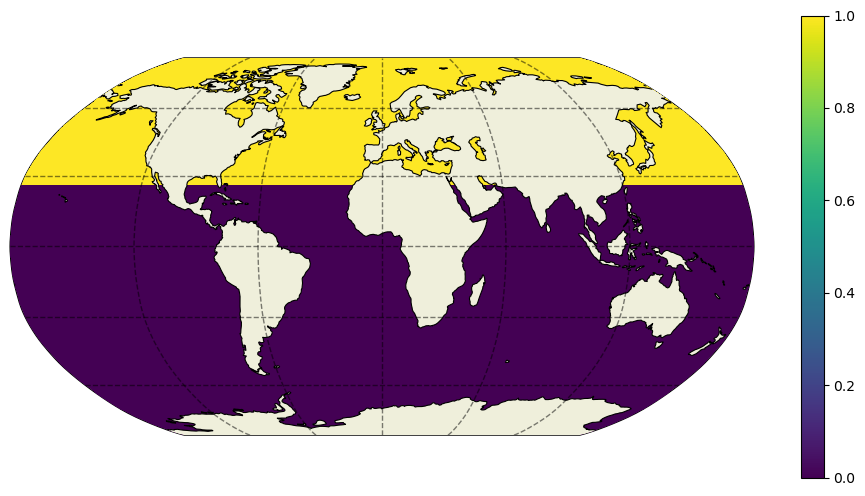

In [8]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ecco_ds.XC,ecco_ds.YC,dome_maskC,
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True);

Again, if this were a lat/lon grid we could simply take a finite difference in the meridional direction. 
The only grid cells with 1's remaining would be at the southern edge of grid cells at approximately 26$^\circ$N.

However, recall that the LLC grid has a different picture.

In [9]:
maskC = ecco_ds.maskC.compute()
maskS = ecco_ds.maskS.compute()
maskW = ecco_ds.maskW.compute()

<Figure size 1200x600 with 0 Axes>

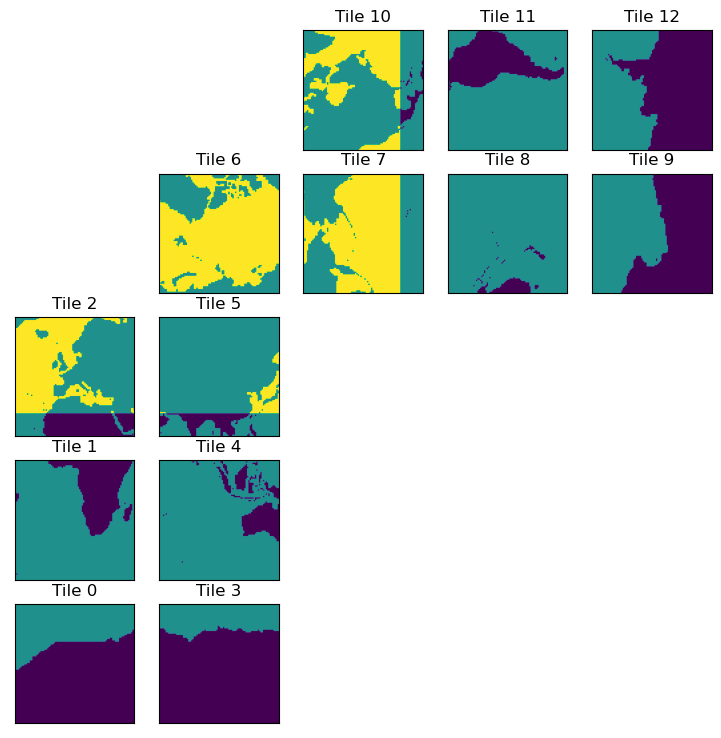

In [10]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(dome_maskC+maskC.isel(k=0), cmap='viridis');

Recall that for tiles 7-12, the y-dimension actually runs East-West. 
Therefore, we want to compute a finite difference in the x-dimension on these tiles to get the latitude band at 26$^\circ$N. 
For tiles 1-5, we clearly want to difference in the y-dimension. 
Things get more complicated on tile 6.

Here we make the [xgcm Grid object](https://xgcm.readthedocs.io/en/latest/api.html#grid) which allows us to compute finite differences in simple one liners. 
This object understands how each of the tiles on the LLC grid connect, because we provide that information. 
To see under the hood, checkout the utility function [get_llc_grid](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/ecco_utils.py) where these connections are defined. 

In [11]:
grid = ecco.get_llc_grid(ecco_ds)

In [12]:
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')

<Figure size 1200x600 with 0 Axes>

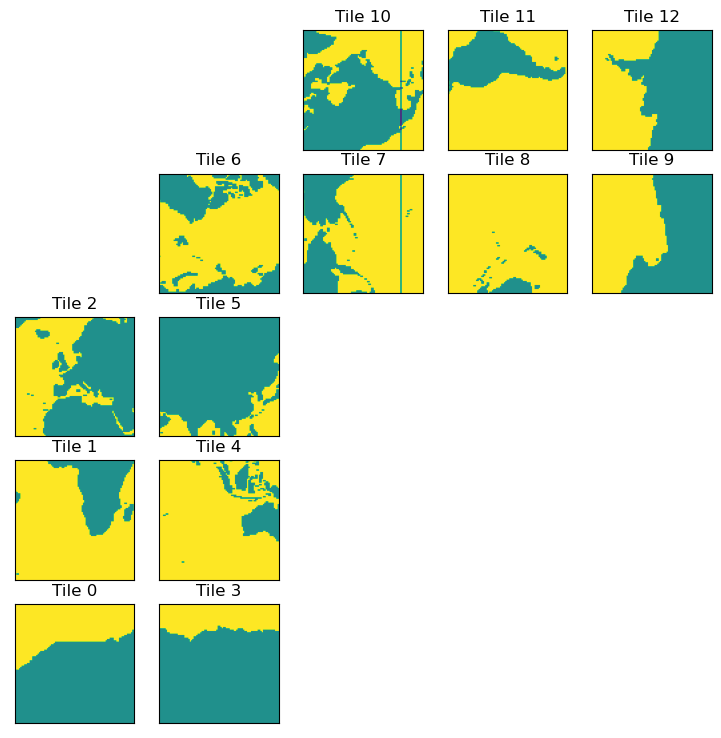

In [13]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(lat_maskW+maskW.isel(k=0), cmap='viridis');

<Figure size 1200x600 with 0 Axes>

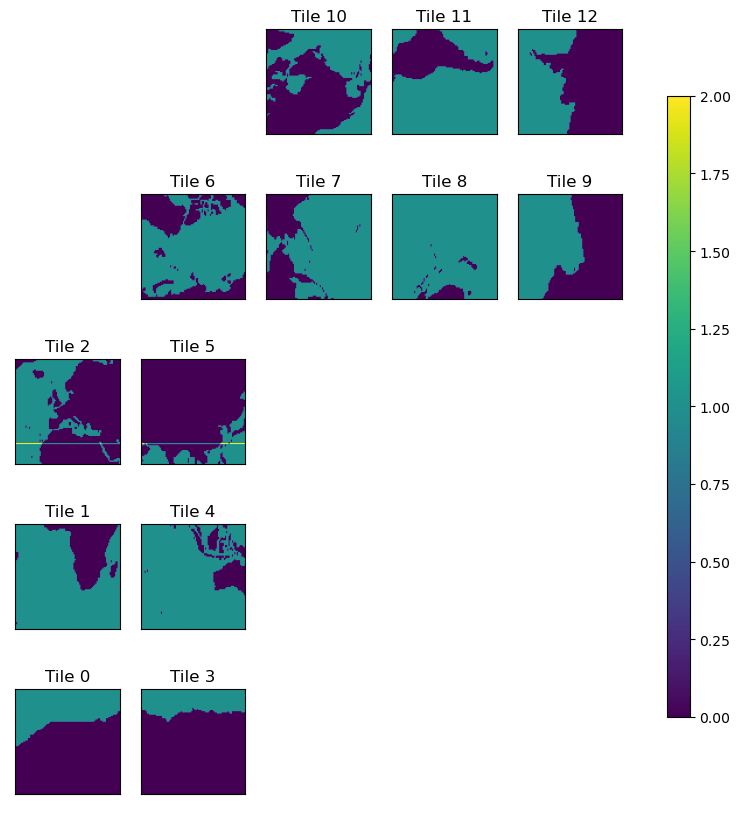

In [14]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(lat_maskS+maskS.isel(k=0), cmap='viridis',show_colorbar=True);

## Select the Atlantic ocean basin for RAPID-MOCHA MHT

Now that we have 26$^\circ$N we just need to select the Atlantic. 
This can be done with the [ecco_v4_py.get_basin](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py) module, specifically `ecco_v4_py.get_basin.get_basin_mask`.
Note that this function requires a mask as an input, and then returns the values within a particular ocean basin.
Therefore, provide the function with `ds['maskC']` for a mask at tracer points, `ds['maskW']` for west grid cell edges, etc.

Note: this mirrors the gcmfaces functionality [ecco_v4/v4_basin.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/ecco_v4/v4_basin.m). 

Here we just want the Atlantic ocean, but lets look at what options we have ...

In [15]:
print(ecco.get_available_basin_names())

['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents']


Notice that, for instance, 'mexico' exists separately from the Atlantic ('atl'). 
This is to provide as fine granularity as possible (and sensible). 
To grab the broader Atlantic ocean basin, i.e. the one people usually refer to, use the option 'atlExt'. 
Similar options exist for the Pacific and Indian ocean basins.

In [16]:
try:
    atl_maskW = ecco.get_basin_mask(basin_name='atlExt',mask=maskW.isel(k=0))
    atl_maskS = ecco.get_basin_mask(basin_name='atlExt',mask=maskS.isel(k=0))
except:
    # depending on how ecco_v4_py is downloaded/installed, 
    # the basin mask file may not be in the location expected by ecco_v4_py.
    # This will download the file from the ECCOv4-py GitHub online.
    basin_path = join(user_home_dir,'ECCOv4-py','binary_data')
    if exists(join(basin_path,'basins.data')) == False:
        import requests
        url_basin_mask = "https://github.com/ECCO-GROUP/ECCOv4-py/raw/master/binary_data/basins.data"
        source_file = requests.get(url_basin_mask, allow_redirects=True)
        if exists(basin_path) == False:
            os.makedirs(basin_path)
        target_file = open(join(basin_path,'basins.data'),'wb')
        target_file.write(source_file.content)
    atl_maskW = ecco.get_basin_mask(basin_name='atlExt',mask=maskW.isel(k=0),\
                                    basin_path=basin_path)
    atl_maskS = ecco.get_basin_mask(basin_name='atlExt',mask=maskS.isel(k=0),\
                                    basin_path=basin_path)

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] C:\cygwin64\home\adelman\Anaconda3\Lib\site-packages\binary_data
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] C:\Users\adelman\ECCOv4-py\binary_data
load_binary_array: loading file C:\Users\adelman\ECCOv4-py\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] C:\Users\adelman\ECCOv4-py\binary_data
load_binary_array: loading file C:\Users\adelman\ECCOv4-py\binary_data\basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compa

Notice that we pass the routine a 2D mask by selecting the first depth level. This is simply to make things run faster.

-179.875 149.875
-180.0 150.0
-89.875 89.875
-90.0 90.0
150.12606037815127 179.87394962184874
150.00001 180.0
-89.875 89.875
-90.0 90.0


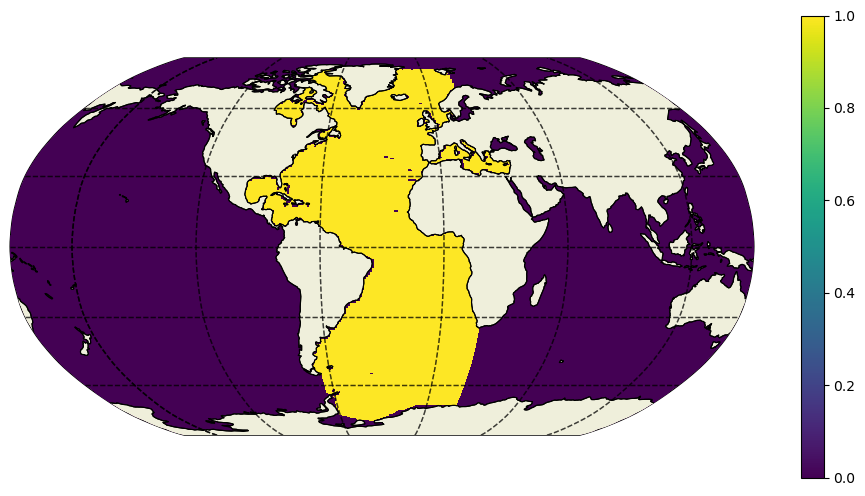

In [17]:
plt.figure(figsize=(12,6))
ecco.plot_proj_to_latlon_grid(ecco_ds.XC,ecco_ds.YC,atl_maskW,
                              projection_type='robin',cmap='viridis',user_lon_0=-30,show_colorbar=True);

## MHT at the approximate RAPID array latitude

This can be done with the [ecco_v4_py.calc_meridional_trsp](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_meridional_trsp.py) module for heat, salt, and volume transport as follows:

```
mvt = ecco_v4_py.calc_meridional_vol_trsp(ecco_ds,lat_vals=26,basin_name='atlExt')
mht = ecco_v4_py.calc_meridional_heat_trsp(ecco_ds,lat_vals=26,basin_name='atlExt')
mst = ecco_v4_py.calc_meridional_salt_trsp(ecco_ds,lat_vals=26,basin_name='atlExt')
```

Additionally, one could compute the overturning streamfunction at this latitude band with `ecco_v4_py.calc_meridional_stf`. 
The inputs are the same as the functions above, see the module [ecco_v4_py.calc_stf](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_stf.py).

In MATLAB, one can use the functions: 

* compute meridional transports: [gcmfaces_calc/calc_MeridionalTransport.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_MeridionalTransport.m)

* compute the overturning streamfunction: [gcmfaces_calc/calc_overturn.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_overturn.m)



### A note about computational performance

When we originally open the dataset with all of the variables, we don't actually load anything into memory. In fact, nothing actually happens until "the last minute". 
For example, the data are only loaded once we do any computation like compute a mean value, plot something, or explicitly provide a `load` command for either the entire dataset or an individual DataArray within the dataset. 
This 'lazy execution' is enabled by the data structure underlying the xarray Datasets and DataArrays, the [dask array](https://docs.dask.org/en/latest/array.html). 

In short, the when the data are opened, dask builds an execution task graph which it saves up to execute at the last minute. 
Dask also allows for parallelism, and by default runs in parallel across [threads for a single core architecture](https://docs.dask.org/en/latest/scheduling.html#local-threads). 
For now, this is what we will show. 

Some quick tips are: 

* Don't load the full 26 years of ECCOv4r4 output (e.g., the ``ecco_ds`` dataset in this notebook) unless you're on a machine with plenty of memory.

* If you're in this situation where you can't load all months into memory, it's a good idea to load 
  a final result before plotting, in case you need to plot it many times in a row, see below...


To illustrate the memory savings from dask, let's see the footprint of loading a *single* year of ``ecco_ds`` into memory:

In [18]:
%%time

from pympler import asizeof
# function to quantify memory footprint of a dataset
def memory_footprint(ds):
    s = 0
    for i in ds.variables.keys():
        s += asizeof.asizeof(ds[i])
    return s


# Create a deep copy of one year (2000) of ecco_ds and load into memory
ecco_ds_2000 = (ecco_ds.isel(time=np.logical_and(ecco_ds.time.values >= np.datetime64('2000-01-01','ns'),\
                                                ecco_ds.time.values < np.datetime64('2001-01-01','ns')))\
               ).copy(deep=True)
ecco_ds_2000_comp = ecco_ds_2000.compute()

memory_footp = memory_footprint(ecco_ds_2000_comp)

print('Memory footprint: ' + str(memory_footp/(2**20)) + ' MB')

Memory footprint: 11727.90315246582 MB
Wall time: 8.83 s


The memory footprint of one year of ``ecco_ds`` is >10 GB! This is large partly because of our use of the dask parallelization architecture, but even without parallel processing the footprint of one year of ``ecco_ds`` is >1 GB. If we loaded all 26 years into memory this could be a problem on a personal laptop. But with dask, we can delay loading these fields into memory, and when we do the computations they are handled in chunks.

In [19]:
%%time

# Compute MHT in Atlantic basin
trsp_x = ((ecco_ds['ADVx_TH'] + ecco_ds['DFxE_TH']) *  atl_maskW).sum('k')
trsp_y = ((ecco_ds['ADVy_TH'] + ecco_ds['DFyE_TH']) *  atl_maskS).sum('k')

## Quantify memory footprint of fields involved
def sum_memory_footprint(da_list):
    memory_footp = 0
    for da in da_to_sum_memory:
        memory_footp += asizeof.asizeof(eval(da))
    return memory_footp

da_to_sum_memory = ["ecco_ds['ADVx_TH']","ecco_ds['DFxE_TH']","atl_maskW","trsp_x",\
                    "ecco_ds['ADVy_TH']","ecco_ds['DFyE_TH']","atl_maskS","trsp_y"]
memory_footp = sum_memory_footprint(da_to_sum_memory)

print('Memory footprint: ' + str(memory_footp/(2**20)) + ' MB')

Memory footprint: 22.68364715576172 MB
Wall time: 4.28 s


In [20]:
%%time

# Apply latitude mask
trsp_x = trsp_x * lat_maskW
trsp_y = trsp_y * lat_maskS

# Sum horizontally
trsp_x = trsp_x.sum(dim=['i_g','j','tile'])
trsp_y = trsp_y.sum(dim=['i','j_g','tile'])

# Add together to get transport
trsp = trsp_x + trsp_y

# Convert to PW
mht = trsp * (1.e-15 * 1000 * 4000)
mht.attrs['units']='PW'


## Quantify memory footprint of fields involved
da_to_sum_memory = ["trsp_x","lat_maskW","trsp_y","lat_maskS","trsp","mht"]
memory_footp = sum_memory_footprint(da_to_sum_memory)

print('Memory footprint: ' + str(memory_footp/(2**20)) + ' MB')

Memory footprint: 35.30622100830078 MB
Wall time: 4.96 s


#### Now that we have computed MHT, lets load the result for iterative plotting

For some reason when dask arrays are plotted, they are computed on the spot but don't stay in memory.
This takes a bit to get the hang of, but keep in mind that this allows us to scale the same code on distributed architecture, so we could use these same routines for high resolution output. This seems worthwhile!

Note that we probably don't need this load statement if we have already loaded the underlying datasets.

In [21]:
%%time
# load mht DataArray
mht = mht.compute();

Wall time: 1min 34s


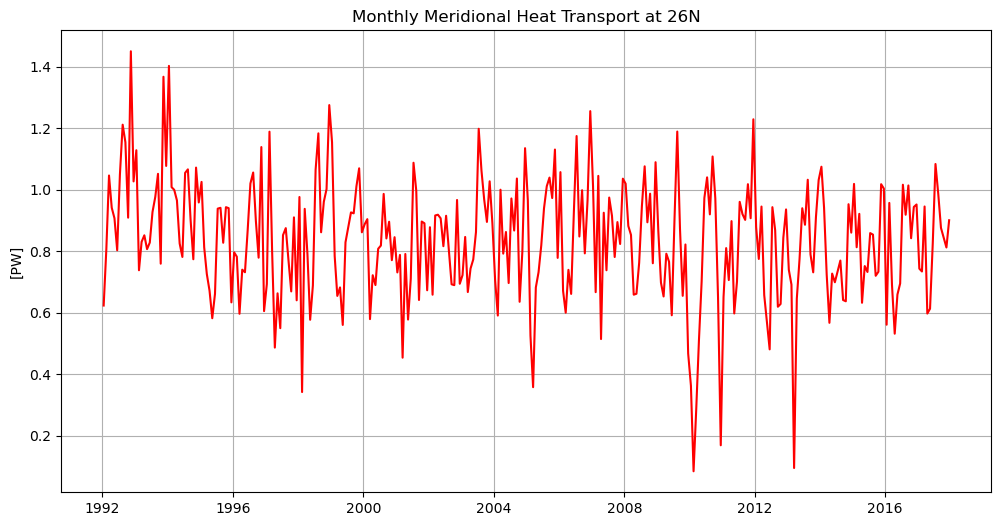

Wall time: 447 ms


In [22]:
%%time
plt.figure(figsize=(12,6))
plt.plot(mht['time'],mht,'r')
plt.grid()
plt.title('Monthly Meridional Heat Transport at 26N')
plt.ylabel(f'[{mht.attrs["units"]}]')
plt.show()

## Now compare global and Atlantic MHT at many latitudes

In [23]:
# pick a temp directory for yourself
nc_save_dir = join(user_home_dir,'Downloads')

if not os.path.isdir(nc_save_dir):
    os.makedirs(nc_save_dir)
    
nc_file = f'{nc_save_dir}/ecco_mht.nc'

Here we will compute MHT along a number of latitudes, integrated both globally and in the Atlantic basin only, and plot the result.

In [24]:
%%time

global_lats = np.arange(-60,60,1)
atl_lats = np.arange(-35,60,1)

## The ecco_v4_py function below does the work of computing MHT at a number of latitudes in a single line.
## However, for large datasets (e.g. 26 years of full-depth global output) it is very slow on a laptop.

# curr_mht = ecco.calc_meridional_heat_trsp(ecco_ds,lat_vals=global_lats)
# curr_mht = curr_mht.mean('time')

## This code runs faster for some reason, perhaps due to the way the latitude masking is done.

ecco_YC = ecco_ds.YC.compute()
trsp_tmean_x = (ecco_ds['ADVx_TH'] + ecco_ds['DFxE_TH']).mean('time')
trsp_tmean_y = (ecco_ds['ADVy_TH'] + ecco_ds['DFyE_TH']).mean('time')
trsp_x = trsp_tmean_x.where(ecco_ds.maskW).compute()
trsp_y = trsp_tmean_y.where(ecco_ds.maskS).compute()

global_trsp_z = np.empty((ecco_ds.dims['k'],len(global_lats)))
atl_trsp_z = np.empty((ecco_ds.dims['k'],len(atl_lats)))
atl_count = 0
for count,lat in enumerate(global_lats):
    dome_maskC = (ecco_YC >= lat).astype('float')
    lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
    lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')
    trsp_x_atlat = (trsp_x * lat_maskW).sum(dim=['tile','j','i_g'])
    trsp_y_atlat = (trsp_y * lat_maskS).sum(dim=['tile','j_g','i'])    
    global_trsp_z[:,count] = (trsp_x_atlat + trsp_y_atlat).values
    
    if lat in atl_lats:
        trsp_x_atlat_Atl = (trsp_x * lat_maskW * atl_maskW).sum(dim=['tile','j','i_g'])
        trsp_y_atlat_Atl = (trsp_y * lat_maskS * atl_maskS).sum(dim=['tile','j_g','i'])
        atl_trsp_z[:,atl_count] = (trsp_x_atlat_Atl + trsp_y_atlat_Atl).values
        atl_count += 1
    
    if count % 10 == 0:
        print('Computed MHT up through ' + str(lat) + ' deg lat')

        
# convert temperature flux to heat transport
global_trsp_z = global_trsp_z*(1.e-15 * 1000 * 4000)
atl_trsp_z = atl_trsp_z*(1.e-15 * 1000 * 4000)

# create DataArrays from Numpy arrays generated in the above loop
global_heat_trsp_z = xr.DataArray(global_trsp_z,\
                                  dims=['k','lat'],\
                                  coords={'Z':(['k'],ecco_ds.Z.data),'lat':global_lats},\
                                 )
global_heat_trsp_z['Z'] = ecco_ds['Z']    # include attributes of Z from ecco_ds
global_heat_trsp_z.attrs['units']='PW'
atl_heat_trsp_z = xr.DataArray(atl_trsp_z,\
                                  dims=['k','lat'],\
                                  coords={'Z':(['k'],ecco_ds.Z.data),'lat':atl_lats},\
                              )
atl_heat_trsp_z['Z'] = ecco_ds['Z']
atl_heat_trsp_z.attrs['units']='PW'
global_heat_trsp = global_heat_trsp_z.sum('k')
global_heat_trsp.attrs['units']='PW'
atl_heat_trsp = atl_heat_trsp_z.sum('k')
atl_heat_trsp.attrs['units']='PW'

# create datasets
mht = global_heat_trsp_z.to_dataset(name='global_heat_trsp_z')
atl = atl_heat_trsp_z.to_dataset(name='atl_heat_trsp_z')
mht['global_heat_trsp'] = global_heat_trsp
atl['atl_heat_trsp'] = atl_heat_trsp

Computed MHT up through -60 deg lat
Computed MHT up through -50 deg lat
Computed MHT up through -40 deg lat
Computed MHT up through -30 deg lat
Computed MHT up through -20 deg lat
Computed MHT up through -10 deg lat
Computed MHT up through 0 deg lat
Computed MHT up through 10 deg lat
Computed MHT up through 20 deg lat
Computed MHT up through 30 deg lat
Computed MHT up through 40 deg lat
Computed MHT up through 50 deg lat
Wall time: 2min 52s


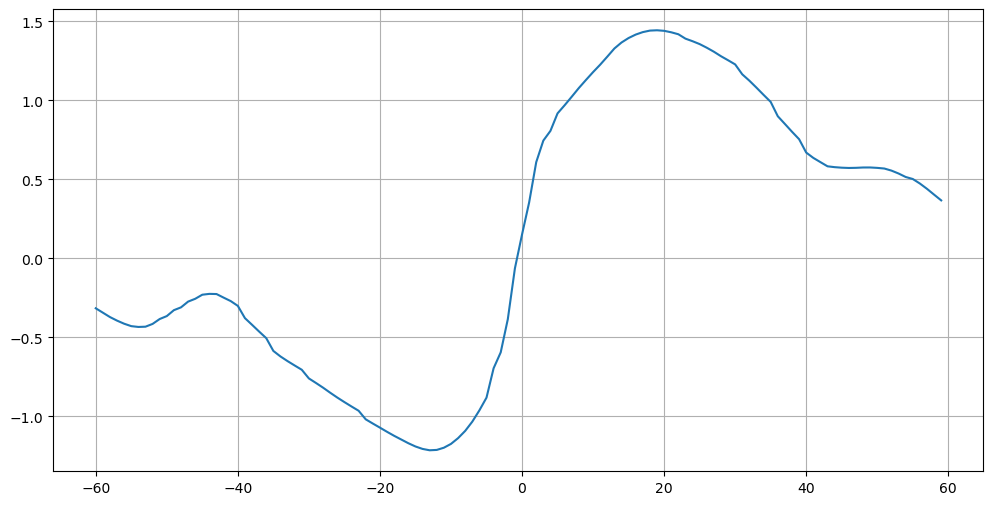

In [25]:
plt.figure(figsize=(12,6))
plt.plot(mht['lat'], mht['global_heat_trsp'])
plt.grid();

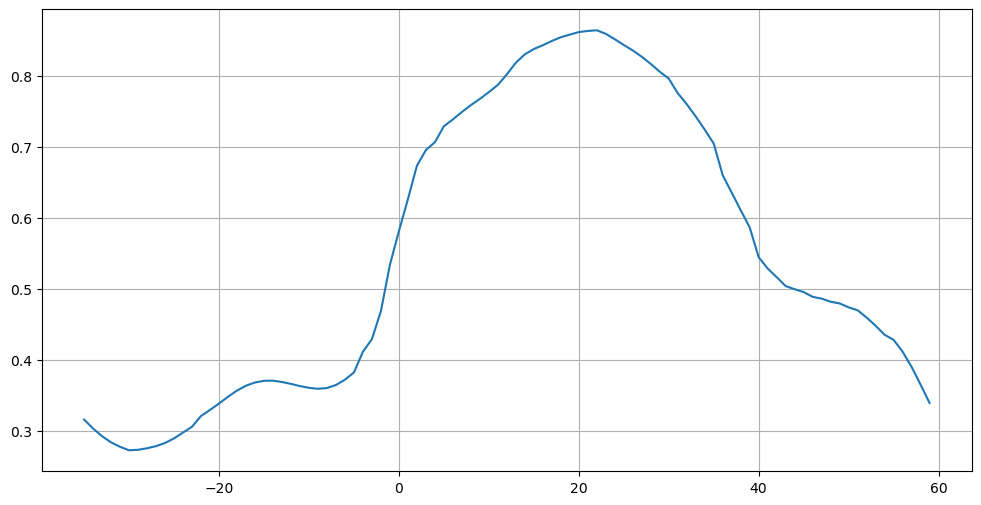

In [26]:
plt.figure(figsize=(12,6))
plt.plot(atl['lat'], atl['atl_heat_trsp'])
plt.grid()

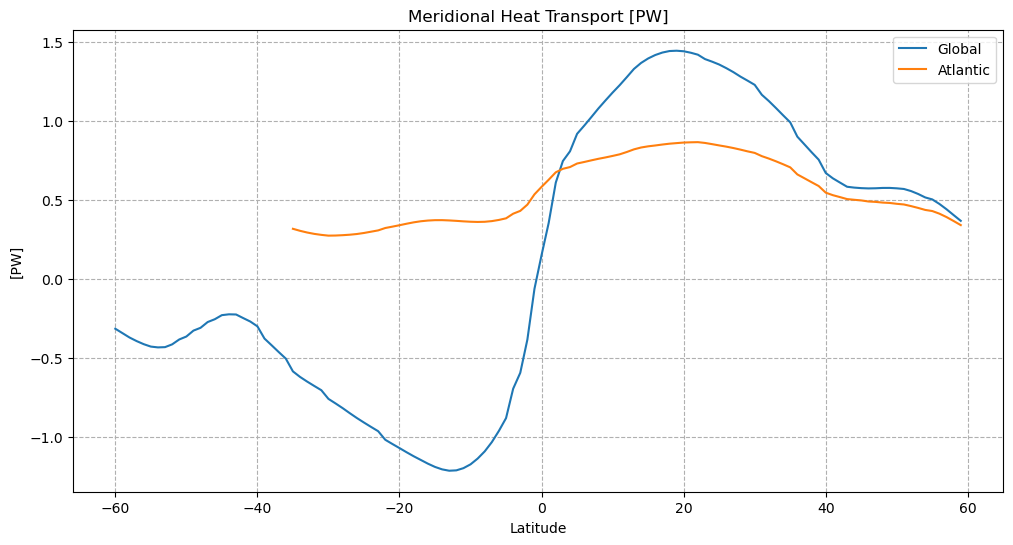

In [27]:
plt.figure(figsize=(12,6))
plt.plot(mht['lat'], mht['global_heat_trsp'])
plt.plot(atl['lat'], atl['atl_heat_trsp'])
plt.legend(('Global','Atlantic'))
plt.grid(linestyle='--')
plt.title(f'Meridional Heat Transport [{mht["global_heat_trsp"].attrs["units"]}]')
plt.ylabel(f'[{mht["global_heat_trsp"].attrs["units"]}]')
plt.xlabel('Latitude')
plt.show()

## MHT as a function of depth


In [28]:
def lat_depth_plot(mht,field,label):
    fig = plt.figure(figsize=(12,6))
    
    # Set up depth coordinate
    depth = -mht['Z']
    stretch_depth = 1000
    
    # Set up colormap and colorbar
    cmap = 'RdBu_r'
    fld = mht[field]
    abs_max = np.max(np.abs([fld.min(),fld.max()]))
    cmin = -abs_max*.1
    cmax = -cmin
    
    # First the "stretched" top plot
    ax1 = plt.subplot(2,1,1)
    p1 = ax1.pcolormesh(mht['lat'],depth,fld,cmap=cmap,vmin=cmin,vmax=cmax)
    plt.grid()

    # Handle y-axis
    ax1.invert_yaxis()
    plt.ylim([stretch_depth, 0])
    ax1.yaxis.axes.set_yticks(np.arange(stretch_depth,0,-100))
    plt.ylabel(f'Depth [{mht["Z"].attrs["units"]}]')

    # Remove top plot xtick label
    ax1.xaxis.axes.set_xticklabels([])

    # Now the rest ...
    ax2 = plt.subplot(2,1,2)
    p2 = ax2.pcolormesh(mht['lat'],depth, fld, cmap=cmap,vmin=cmin,vmax=cmax)
    plt.grid()

    # Handle y-axis
    ax2.invert_yaxis()
    plt.ylim([4000, 1000])
    #yticks = np.flip(np.arange(6000,stretch_depth,-1000))
    #ax2.yaxis.axes.set_yticks(yticks)
    plt.ylabel(f'Depth [{mht["Z"].attrs["units"]}]')
               
    # Label  axis
    plt.xlabel('Latitude')

    # Reduce space between subplots
    fig.subplots_adjust(hspace=0.0)

    # Make a single title
    fig.suptitle(f'{label} time mean meridional heat transport',verticalalignment='top',fontsize=24)

    # Make an overyling colorbar
    fig.subplots_adjust(right=0.83)
    cbar_ax = fig.add_axes([0.87, 0.1, 0.025, 0.8])
    fig.colorbar(p2,cax=cbar_ax)
    cbar_ax.set_ylabel(f'[{mht[field].attrs["units"]}]')
                       
    plt.show()

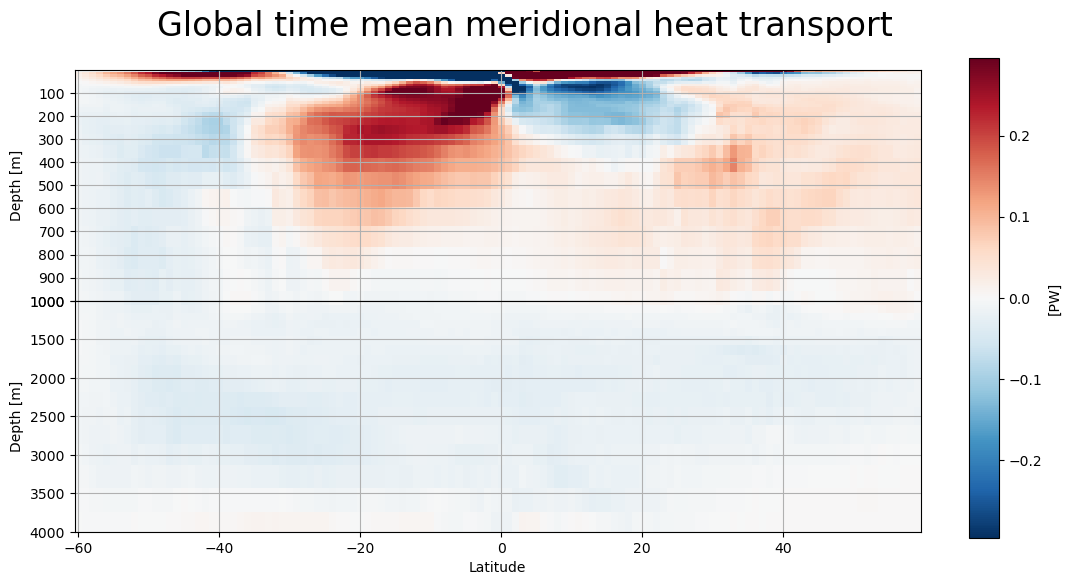

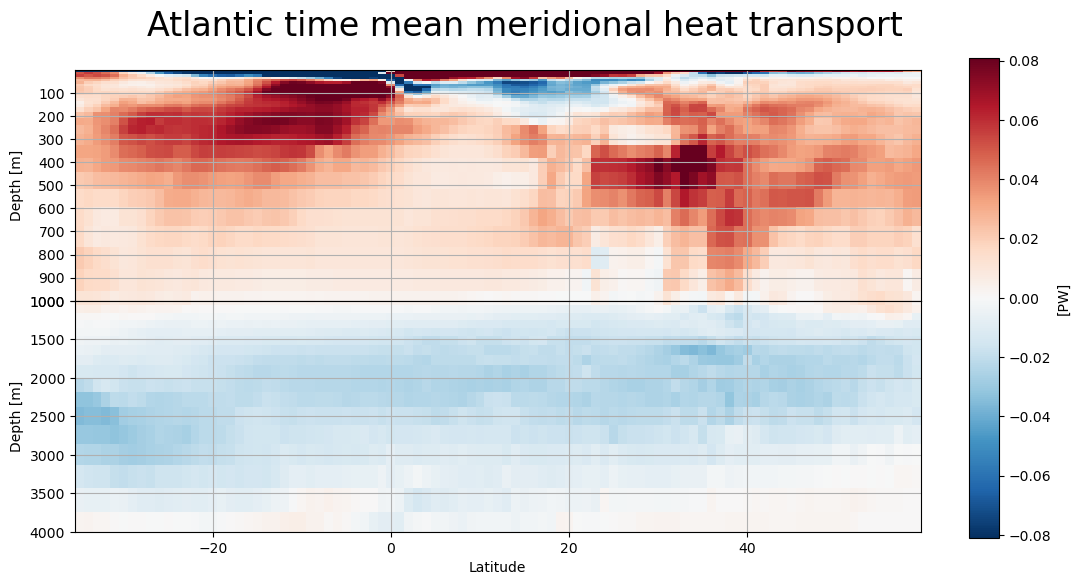

In [29]:
lat_depth_plot(mht,'global_heat_trsp_z','Global')
lat_depth_plot(atl,'atl_heat_trsp_z','Atlantic')

## Exercise: reproduce figure from (Ganachaud and Wunsch, 2000)

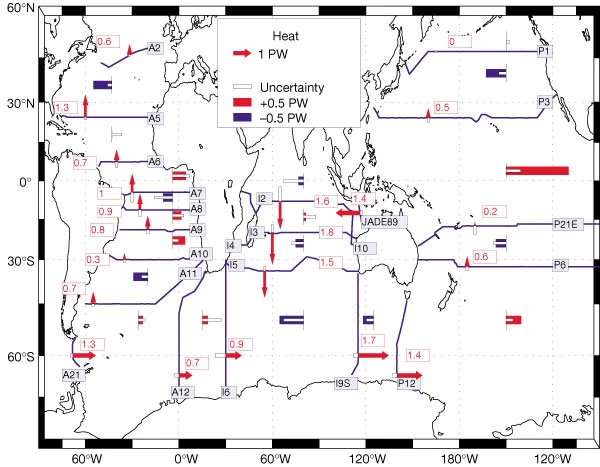

2023-05-02 21:25:35,347 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63361', name: 3, status: running, memory: 0, processing: 0>
2023-05-02 21:25:35,389 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:63376', name: 0, status: running, memory: 0, processing: 0>
2023-05-02 21:25:35,430 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63376'.
2023-05-02 21:25:35,438 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:63361'.
2023-05-02 21:25:36,721 - distributed.nanny - WARNING - Restarting worker
2023-05-02 21:25:39,522 - distributed.nanny - WARNING - Restarting worker
2023-05-03 19:30:38,669 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:55156', name: 3, status: running, me

In [30]:
from IPython.display import Image
Image('../figures/ganachaud_mht.png')

Note: to reproduce this figure, you may need to pair latitude masks with those defined through the `get_section_masks` module. An example of this functionality is shown in the next tutorial. 

## References

Ganachaud, A., & Wunsch, C. (2000). Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data. Nature, 408(6811), 453-7. doi:http://dx.doi.org.ezproxy.lib.utexas.edu/10.1038/35044048